# Rescale rat model to match Long-Evans rat skeletal parameters

### Changes include
* Global scaling to approximate average rat size.
* Rescaling of long bones to measured lengths to preserve proportions. 

In [1]:
from dm_control import mjcf
from dm_control import viewer
from dm_control import mujoco
from dm_control import suite
import numpy as np
import re
import pandas as pd
from dm_control.mujoco.wrapper.mjbindings import mjlib
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

## Define useful parameters and functions

In [2]:
base_model_path = '/home/diego/code/olveczky/dm/stac/models/to_tune/rat_june24.xml'
# temp_model_path is the model used by .../dm_control/suite/rat.py for easy iteration.
temp_model_path = '/home/diego/.envs/mujoco200_3.7/lib/python3.6/site-packages/dm_control/suite/rat_temp.xml'

def view_model():
    # Load an environment from the Control Suite.
    env = suite.load(domain_name="rat", task_name="stand")
    # Launch the viewer application.
    viewer.launch(env)

def load_model(model_path):
    return mjcf.from_path(model_path)

def write_model(model, save_path):
    s = model.to_xml_string()
    s = re.sub('rat_skin.*skn', 'rat_skin.skn', s)
    with open(save_path , 'w') as f:
        f.write(s)

# Save measured data (mm) and the bone-site pairs they correspond to 
bone_lengths = {'humerus': 30.0,
                'radius': 29.6,
                'femur': 36.5,
                'tibia': 42.8,
                'metatarsal': 23.4,
                'hand': 9.0}
joint_pairs = {'humerus': ['shoulder_L', 'elbow_L'],
               'radius': ['elbow_L', 'wrist_L'],
               'femur': ['hip_L', 'knee_L'],
               'tibia': ['knee_L', 'ankle_L'],
               'metatarsal': ['ankle_L', 'toe_L'],
               'hand': ['wrist_L', 'finger_L']}

# skull_width = 38.8
# skull_length = 57

skull_dims = {'length': [47.4], 'width': [20.2]}
skull_pairs = {'length': ['head', 'skull_T0_collision'],
              'width': ['eye_R_collision', 'eye_L_collision']}



base_model = load_model(base_model_path)
print(base_model.to_xml_string())
write_model(base_model, temp_model_path)
view_model()

<mujoco model="rat">
  <compiler angle="radian"/>
  <size njmax="2000" nconmax="1000"/>
  <visual>
    <quality shadowsize="2048"/>
  </visual>
  <statistic meansize="0.003"/>
  <default>
    <default class="/">
      <mesh scale="1 1 1"/>
      <joint limited="true" solreflimit="0.01 1" solimplimit="0.98999999999999999 0.99990000000000001 0" armature="6e-08" damping="0.0001"/>
      <geom friction="0.69999999999999996 0.0050000000000000001 0.0001" solref="0.0050000000000000001 1"/>
      <site group="3" rgba="0 0 1 1"/>
      <general ctrllimited="true" ctrlrange="-1 1" gainprm="0.01"/>
      <default class="bone">
        <geom contype="0" conaffinity="0" group="0" rgba="0.5 0.5 0.5 1" density="1100.0"/>
      </default>
      <default class="collision">
        <geom contype="1" conaffinity="1" condim="1" group="2"/>
        <default class="collision_primitive">
          <geom type="capsule" group="2" rgba="0 0.5 0.5 1" density="500.0"/>
          <default class="collision_primitiv

## View the base model

In [3]:
# print([p for p in env.physics.named.model._asdict().keys() if 'jnt' in p])
# env.physics.named.data.xpos

In [4]:
def get_bone_distance(physics, joint_pair):
    joint0 = physics.named.data.site_xpos[joint_pair[0]].copy()
    joint1 = physics.named.data.site_xpos[joint_pair[1]].copy()
    length = np.sqrt(np.sum((joint0 - joint1)**2))
    return length

def get_bone_ratios(bone_dict):
    n_bones = len(bone_dict.keys())
    ratio_mat = np.zeros((n_bones,n_bones))
    ratio_dict = {}
    for i, (bone0, length0) in enumerate(bone_dict.items()):
        for j, (bone1, length1) in enumerate(bone_dict.items()):
            ratio = length0/length1
            ratio_mat[i, j] = ratio
            ratio_dict[bone0 + '-' + bone1] = ratio
            
    return ratio_dict, ratio_mat

def get_skull_dims(physics):
    atlas_pos = physics.named.data.xpos['vertebra_atlant'].copy()
    print(atlas_pos)
    T0_pos = physics.named.data.geom_xpos['skull_T0_collision'].copy()
    length = np.sqrt(np.sum((atlas_pos - T0_pos)**2))*1000
    
    eyeL_pos = physics.named.data.geom_xpos['eye_L_collision'].copy()
    eyeR_pos = physics.named.data.geom_xpos['eye_R_collision'].copy()
    width = np.sqrt(np.sum((eyeL_pos - eyeR_pos)**2))*1000
    return {'length': length, 'width': width}


## Apply global downscaling, and long-bone length matching

In [5]:
model = load_model(base_model_path)
write_model(base_model, temp_model_path)
# Globally scale down the model
def scale_model(model, global_scale_ratio=.82):
    for g in model.find_all('geom'):
        if g.pos is not None and 'eye' not in g.name:
            g.pos *= global_scale_ratio
    for b in model.find_all('body'):
        if b.pos is not None and 'eye' not in g.name:
            b.pos *= global_scale_ratio
    for s in model.find_all('site'):
        if s.pos is not None and 'eye' not in g.name:
            s.pos *= global_scale_ratio
    return model
model = scale_model(model)
write_model(model, temp_model_path)

env = suite.load(domain_name="rat", task_name="stand")
model_lengths = {k: get_bone_distance(env.physics, jp)*1000 for k, jp in joint_pairs.items()}
length_difference = {k: bone_lengths[k] - model_lengths[k] for k in model_lengths.keys()}
bone_ratios, bone_ratio_mat = get_bone_ratios(bone_lengths)
model_ratios, model_ratio_mat = get_bone_ratios(model_lengths)
print('Model lengths:', model_lengths)
print('Bone lengths:', bone_lengths)
ratio = [bone_lengths[k]/model_lengths[k] for k in model_lengths.keys()]
print('Ratio of bone_lengths to model_lengths', ratio)

# Scale particular arm and leg joints to match literature
def scale_arms_and_legs(model):
    env = suite.load(domain_name="rat", task_name="stand")
    model_lengths = {k: get_bone_distance(env.physics, jp)*1000 for k, jp in joint_pairs.items()}
    ratio = [bone_lengths[k]/model_lengths[k] for k in model_lengths.keys()]
    model_name_pairs = {'humerus': ['elbow', 'humerus', 'lower_arm'],
                   'radius': ['wrist', 'radius', 'ulna', 'hand'],
                   'femur': ['knee', 'upper_leg_L0_collision', 'upper_leg_R0_collision', 'lower_leg'],
                   'tibia': ['ankle', 'foot'],
                   'metatarsal': ['toe'],
                   'hand': ['finger', 'hand_L_collision', 'hand_R_collision']}
    for i, (bone, model_id) in enumerate(model_name_pairs.items()):
        for g in model.find_all('geom'):
            if any(part in g.name for part in model_id):
                if bone == 'radius' and any(part in g.name for part in ['hand_L_collision', 'hand_R_collision']):
                    continue
                if g.pos is not None:
                    g.pos *= ratio[i]
                if g.size is not None:
                    g.size *= ratio[i]
        for b in model.find_all('body'):
            if any(part in b.name for part in model_id):
                if b.pos is not None:
                    b.pos *= ratio[i]
        for s in model.find_all('site'):
            if any(part in s.name for part in model_id):
                if s.pos is not None:
                    s.pos *= ratio[i]
    return model
model = scale_arms_and_legs(model)
write_model(model, temp_model_path)


# # Scale particular arm and leg joints to match literature
# def scale_skull(model):
#     env = suite.load(domain_name="rat", task_name="stand")
#     model_dims = get_skull_dims(env.physics)
#     ratio = [skull_dims[k]/model_dims[k] for k in model_dims.keys()]
#     print('model_dims', model_dims)
#     print(ratio)
#     model_name_pairs = {'length': ['jaw', 'skull', 'eye'],
#                        'width': ['jaw', 'skull', 'eye']}
#     for i, (bone, model_id) in enumerate(model_name_pairs.items()):
#         for g in model.find_all('geom'):
#             if any(part in g.name for part in model_id):
#                 if g.pos is not None:
#                     g.pos[i] *= ratio[i]
#                 if 'eye' in g.name:
#                     continue
#                 if g.size is not None:
#                     g.size[i] *= ratio[i]
#         for b in model.find_all('body'):
#             if any(part in b.name for part in model_id):
#                 if b.pos is not None:
#                     b.pos[i] *= ratio[i]
#         for s in model.find_all('site'):
#             if any(part in s.name for part in model_id):
#                 if s.pos is not None:
#                     s.pos[i] *= ratio[i]
#     return model
# model = scale_skull(model)
# write_model(model, temp_model_path)

Model lengths: {'humerus': 24.599999999999998, 'radius': 24.271999999999995, 'femur': 29.930000000000003, 'tibia': 35.096000000000004, 'metatarsal': 19.187999999999995, 'hand': 7.379999999999997}
Bone lengths: {'humerus': 30.0, 'radius': 29.6, 'femur': 36.5, 'tibia': 42.8, 'metatarsal': 23.4, 'hand': 9.0}
Ratio of bone_lengths to model_lengths [1.2195121951219514, 1.2195121951219516, 1.2195121951219512, 1.219512195121951, 1.2195121951219514, 1.2195121951219516]


## Check to make sure everything worked as planned

In [6]:
env = suite.load(domain_name="rat", task_name="stand")
model_lengths = {k: get_bone_distance(env.physics, jp)*1000 for k, jp in joint_pairs.items()}
length_difference = {k: bone_lengths[k] - model_lengths[k] for k in model_lengths.keys()}
bone_ratios, bone_ratio_mat = get_bone_ratios(bone_lengths)
model_ratios, model_ratio_mat = get_bone_ratios(model_lengths)
print('Model lengths:', model_lengths)
print('Bone lengths:', bone_lengths)
ratio = [bone_lengths[k]/model_lengths[k] for k in model_lengths.keys()]
print('Ratio of bone_lengths to model_lengths', ratio)


# model_dims = get_skull_dims(env.physics)
# ratio = [skull_dims[k]/model_dims[k] for k in model_dims.keys()]
# print('Ratio of bone_lengths to model_lengths', ratio)

Model lengths: {'humerus': 30.0, 'radius': 29.600000000000016, 'femur': 36.5, 'tibia': 42.79999999999999, 'metatarsal': 23.4, 'hand': 8.999999999999998}
Bone lengths: {'humerus': 30.0, 'radius': 29.6, 'femur': 36.5, 'tibia': 42.8, 'metatarsal': 23.4, 'hand': 9.0}
Ratio of bone_lengths to model_lengths [1.0, 0.9999999999999996, 1.0, 1.0000000000000002, 1.0, 1.0000000000000002]


## View the model

In [7]:
view_model()

## Modify mass distribution by changing density

In [8]:
mass_dist_path = '/home/diego/data/dm/stac/body_measurements/Mass_distribution.xlsx'
mass_data = pd.ExcelFile(mass_dist_path)
data = mass_data.parse('Sheet1')
data = data.to_numpy()
parts = data[1:,0]
masses = data[1:,1]
model_mass = .310
real_ratios = {name: val/masses[0] for name,val in zip(parts, masses)}
expected_masses = {}
for key, ratio in real_ratios.items():
    if any([side in key for side in ['_L', '_R']]):
        right = key[:-2] + '_R'
        left = key[:-2] + '_L'

        ratio = (real_ratios[right] + real_ratios[left]) / 2.
    expected_masses[key] = ratio*model_mass
# expected_masses['tail'] = expected_masses['tail_base_to_mid'] = expected_masses['tail_mid_to_tip']
# Keys are the keywords that correspond to geom(s) in the model.
# Values are keywords for the corresponding part in real data.
geom_mass_key_pairs = {
    'torso': 'torso',
    'pelvis': 'gut_liver',
    'upper_leg_L': 'upper_limb_L',
    'upper_leg_R': 'upper_limb_R',
    'lower_leg_L': 'lower_limb_L',
    'lower_leg_R': 'lower_limb_R',
    'foot_L': 'foot_L',
    'foot_R': 'foot_R',
    'skull': 'skull',
    'jaw': 'jaw',
    'scapula_L': 'scapula_L',
    'scapula_R': 'scapula_R',
    'upper_arm_L': 'humerus_L',
    'upper_arm_R': 'humerus_R',
    'lower_arm_R': 'forelimb_R',
    'lower_arm_L': 'forelimb_L',
    'hand_L': 'paw_L',
    'hand_R': 'paw_R',
    'vertebra_C': 'Tail'}
total = 0
for _, v in geom_mass_key_pairs.items():
    total += expected_masses[v]
    
print(total)

0.31284403669724775


In [9]:
print(expected_masses.keys())

dict_keys(['total', 'leg_L', 'leg_R', 'Tail', 'arm_R', 'arm_L', 'head_trunk_gut', 'head', 'torso_half_liver', 'gut_half_liver', 'gut_liver', 'torso', 'intestines_stomach', 'liver', 'pelvis_kidneys', 'jaw', 'skull', 'tail_base_to_mid', 'tail_mid_to_tip', 'scapula_L', 'humerus_L', 'forelimb_L', 'paw_L', 'scapula_R', 'humerus_R', 'forelimb_R', 'paw_R', 'foot_L', 'lower_limb_L', 'upper_limb_L', 'foot_R', 'lower_limb_R', 'upper_limb_R'])


In [10]:
env = suite.load(domain_name="rat", task_name="stand")
model_masses = env.physics.named.model.body_mass
print(env.physics.named.model._asdict().keys())
[print(k ) for k in env.physics.named.model._asdict().keys() if 'class' in k]
print(model_masses)

dict_keys(['actuator_acc0', 'actuator_biasprm', 'actuator_biastype', 'actuator_cranklength', 'actuator_ctrllimited', 'actuator_ctrlrange', 'actuator_dynprm', 'actuator_dyntype', 'actuator_forcelimited', 'actuator_forcerange', 'actuator_gainprm', 'actuator_gaintype', 'actuator_gear', 'actuator_group', 'actuator_length0', 'actuator_lengthrange', 'actuator_trnid', 'actuator_trntype', 'actuator_user', 'body_dofadr', 'body_dofnum', 'body_geomadr', 'body_geomnum', 'body_inertia', 'body_invweight0', 'body_ipos', 'body_iquat', 'body_jntadr', 'body_jntnum', 'body_mass', 'body_mocapid', 'body_parentid', 'body_pos', 'body_quat', 'body_rootid', 'body_sameframe', 'body_simple', 'body_subtreemass', 'body_user', 'body_weldid', 'cam_bodyid', 'cam_fovy', 'cam_ipd', 'cam_mat0', 'cam_mode', 'cam_pos', 'cam_pos0', 'cam_poscom0', 'cam_quat', 'cam_targetbodyid', 'cam_user', 'dof_M0', 'dof_Madr', 'dof_armature', 'dof_bodyid', 'dof_damping', 'dof_frictionloss', 'dof_invweight0', 'dof_jntid', 'dof_parentid', '

In [11]:
part_mass = 0
env = suite.load(domain_name="rat", task_name="stand")
model_masses = env.physics.named.model.body_mass
model_masses_pre = np.copy(model_masses[:])
model_names = model_masses.axes.row.names
for model_kw, real_kw in geom_mass_key_pairs.items():
#     for g in model.find_all('geom'):
#         if model_kw in g.name:
#             part_mass += env.physics.named.model.body_mass[model_kw]
    for name in model_names:
        if model_kw in name:
            part_mass += model_masses[name]
    mass_ratio = expected_masses[real_kw]/part_mass
    for g in model.find_all('geom'):
         if model_kw in g.name:
            if g.density is None:
                g.density = 500.0 # taken from collision class
            g.density = g.density * mass_ratio
    part_mass = 0
            
write_model(model, temp_model_path)

FieldIndexer(body_mass):
 0               world [ 0       ]
 1               torso [ 0.0607  ]
 2          vertebra_1 [ 0.00209 ]
 3          vertebra_2 [ 0.00209 ]
 4          vertebra_3 [ 0.00209 ]
 5          vertebra_4 [ 0.00209 ]
 6          vertebra_5 [ 0.00209 ]
 7          vertebra_6 [ 0.00209 ]
 8              pelvis [ 0.152   ]
 9         upper_leg_L [ 0.0123  ]
10         lower_leg_L [ 0.00853 ]
11              foot_L [ 0.0019  ]
12               toe_L [ 0.000512]
13         upper_leg_R [ 0.0123  ]
14         lower_leg_R [ 0.00853 ]
15              foot_R [ 0.0019  ]
16               toe_R [ 0.000512]
17         vertebra_C1 [ 0.00209 ]
18         vertebra_C2 [ 0.00129 ]
19         vertebra_C3 [ 0.00124 ]
20         vertebra_C4 [ 0.000794]
21         vertebra_C5 [ 0.000326]
22         vertebra_C6 [ 0.000254]
23         vertebra_C7 [ 0.000183]
24         vertebra_C8 [ 0.000136]
25         vertebra_C9 [ 0.000163]
26        vertebra_C10 [ 0.000224]
27        vertebra_C11 [ 8.91e

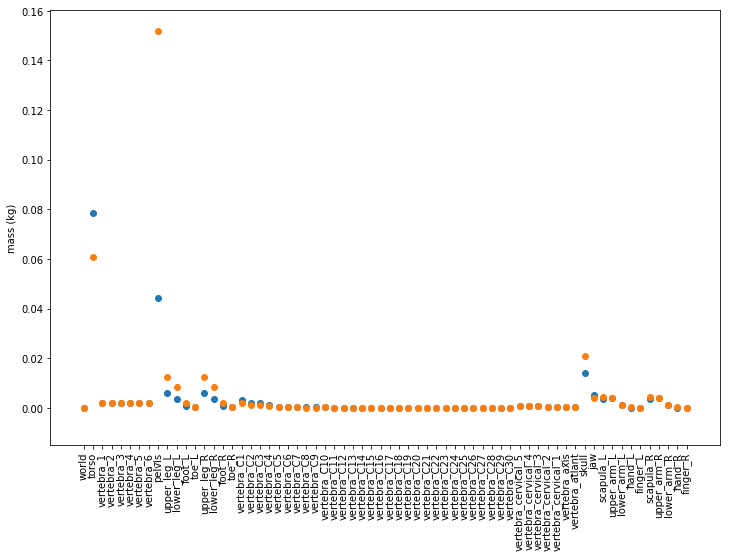

In [12]:
env = suite.load(domain_name="rat", task_name="stand")
model_masses_post = env.physics.named.model.body_mass
fig, ax = plt.subplots(figsize=(12,8))
x = range(len(model_names))
plt.scatter(x, model_masses_pre)
plt.scatter(x, model_masses_post[:])

plt.xticks(x)
_ = ax.set_xticklabels(model_names, rotation=90)

plt.ylabel('mass (kg)')
plt.rcParams['font.size'] = 10
print(model_masses_post)

vertebra_total = 0
for name in model_names:
    if 'vertebra_c' in name:
        vertebra_total += model_masses_post[name]
    if any([('vertebra_' + num) in name for num in ['1','2','3','4','5','6']]):
        vertebra_total += model_masses_post[name]
        
print(vertebra_total)

0.31
{'total': 0.31, 'leg_L': 0.022752293577981652, 'leg_R': 0.022752293577981652, 'Tail': 0.007584097859327217, 'arm_R': 0.010428134556574922, 'arm_L': 0.010428134556574922, 'head_trunk_gut': 0.23700305810397554, 'head': 0.024648318042813457, 'torso_half_liver': 0.0919571865443425, 'gut_half_liver': 0.12134556574923547, 'gut_liver': 0.15168195718654434, 'torso': 0.060672782874617734, 'intestines_stomach': 0.0426605504587156, 'liver': 0.03318042813455657, 'pelvis_kidneys': 0.07678899082568807, 'jaw': 0.0037920489296636084, 'skull': 0.020856269113149844, 'tail_base_to_mid': 0.005688073394495413, 'tail_mid_to_tip': 0.0018960244648318042, 'scapula_L': 0.0042660550458715595, 'humerus_L': 0.0037920489296636084, 'forelimb_L': 0.0028440366972477065, 'paw_L': 0.00047400611620795105, 'scapula_R': 0.0042660550458715595, 'humerus_R': 0.0037920489296636084, 'forelimb_R': 0.0028440366972477065, 'paw_R': 0.00047400611620795105, 'foot_L': 0.0018960244648318042, 'lower_limb_L': 0.008532110091743119, '

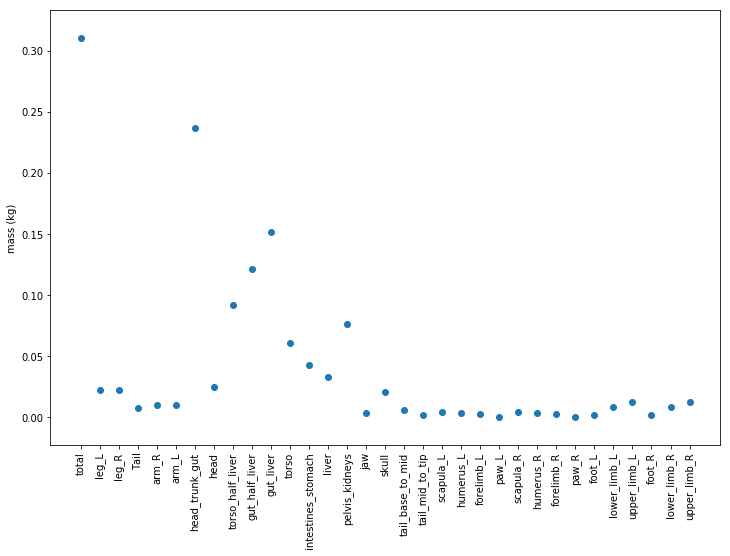

In [13]:
env = suite.load(domain_name="rat", task_name="stand")
model_masses_post = env.physics.named.model.body_mass
fig, ax = plt.subplots(figsize=(12,8))
x = range(len(expected_masses.keys()))
plt.scatter(x, expected_masses.values())

plt.xticks(x)
_ = ax.set_xticklabels(expected_masses.keys(), rotation=90)
print(expected_masses['total'])
plt.ylabel('mass (kg)')
plt.rcParams['font.size'] = 10
print(expected_masses)

In [14]:
mass = mjlib.mj_getTotalmass(env.physics.model.ptr)
print("Total mass is: %f kilograms" % (mass))



Total mass is: 0.327508 kilograms
